In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import  pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import scipy
import os
from sklearn.decomposition import PCA
import shap

#from ucimlrepo import fetch_ucirepo

import warnings
warnings.filterwarnings('ignore')

#from mappings import *
from functs import *

/home/xannadoo/miniconda3/envs/AFexam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Constants

In [2]:
seed = 0
np.random.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)

In [3]:
# from_begin=True to not include information from the first and second semester
# nationality=Fals to not include nationality column - there are few international students and there is another column for being international

DOWNLOAD = False
from_begin=True
nationality=False

if DOWNLOAD:
    features, features_full, labels = load_data(from_begin=from_begin, nationality=nationality)

    features.to_csv('data/features.csv', index=False)
    features_full.to_csv('data/features_full.csv', index=False)
    labels.to_csv('data/labels.csv', index=False)

else:
    features = pd.read_csv('data/features.csv')
    features_full = pd.read_csv('data/features_full.csv')
    labels = pd.read_csv('data/labels.csv')

In [4]:
features_full.head(10)

,marital_status,application_mode,application_order,course,daytime/evening_attendance,previous_qualification,previous_qualification_grade,mothers_qualification,fathers_qualification,mothers_occupation,...,debtor,tuition_fees_up_to_date,gender,scholarship_holder,age_at_enrollment,international,unemployment_rate,inflation_rate,gdp,graduated
0,single,2nd_phase_general_contingent,5,animation_and_multimedia_design,1,upper_secondary,122.0,upper_secondary,upper_secondary,unskilled,...,0,1,1,0,20,0,10.8,1.4,1.74,0
1,single,international_student_bachelor,1,tourism,1,upper_secondary,160.0,upper_secondary,higher_education,skilled,...,0,0,1,0,19,0,13.9,-0.3,0.79,1
2,single,1st_phase_general_contingent,5,communication_design,1,upper_secondary,122.0,basic,basic,unskilled,...,0,0,1,0,19,0,10.8,1.4,1.74,0
3,single,2nd_phase_general_contingent,2,journalism_and_communication,1,upper_secondary,122.0,basic,basic,unskilled,...,0,1,0,0,20,0,9.4,-0.8,-3.12,1
4,married,over_23_years_old,1,social_service,0,upper_secondary,100.0,basic,basic,unskilled,...,0,1,0,0,45,0,13.9,-0.3,0.79,1
5,married,over_23_years_old,1,management,0,upper_secondary,133.1,basic,basic,unskilled,...,1,1,1,0,50,0,16.2,0.3,-0.92,1
6,single,1st_phase_general_contingent,1,nursing,1,upper_secondary,142.0,upper_secondary,basic,skilled,...,0,1,0,1,18,0,15.5,2.8,-4.06,1
7,single,3rd_phase_general_contingent,4,tourism,1,upper_secondary,119.0,basic,basic,unskilled,...,0,0,1,0,22,0,15.5,2.8,-4.06,0
8,single,1st_phase_general_contingent,3,social_service,1,upper_secondary,137.0,upper_secondary,upper_secondary,unskilled,...,0,1,0,1,21,1,16.2,0.3,-0.92,1
9,single,1st_phase_general_contingent,1,social_service,1,upper_secondary,138.0,upper_secondary,upper_secondary,skilled,...,1,0,0,0,18,0,8.9,1.4,3.51,0


In [5]:
protected_cols=[x for x in features.columns if ('occupation' in x) or (x=='gender')]
groups = features[protected_cols]

In [6]:
features.head(10)

,application_order,daytime/evening_attendance,previous_qualification_grade,admission_grade,displaced,educational_special_needs,debtor,tuition_fees_up_to_date,gender,scholarship_holder,...,mothers_occupation_skilled,fathers_occupation_managerial,fathers_occupation_other,fathers_occupation_professional,fathers_occupation_skilled,marital_status_divorced,marital_status_facto union,marital_status_legally separated,marital_status_married,marital_status_widower
0,5,1,122.0,127.3,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,160.0,142.5,1,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
2,5,1,122.0,124.8,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2,1,122.0,119.6,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,0,100.0,141.5,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
5,1,0,133.1,114.8,0,0,1,1,1,0,...,0,0,0,0,1,0,0,0,1,0
6,1,1,142.0,128.4,1,0,0,1,0,1,...,1,0,0,1,0,0,0,0,0,0
7,4,1,119.0,113.1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,3,1,137.0,129.3,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
9,1,1,138.0,123.0,1,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,0


In [7]:
features.describe()

,application_order,daytime/evening_attendance,previous_qualification_grade,admission_grade,displaced,educational_special_needs,debtor,tuition_fees_up_to_date,gender,scholarship_holder,...,mothers_occupation_skilled,fathers_occupation_managerial,fathers_occupation_other,fathers_occupation_professional,fathers_occupation_skilled,marital_status_divorced,marital_status_facto union,marital_status_legally separated,marital_status_married,marital_status_widower
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,1.727848,0.890823,132.613314,126.978119,0.548373,0.011528,0.113698,0.880651,0.351718,0.248418,...,0.352622,0.031193,0.047920,0.106465,0.388110,0.020570,0.005651,0.001356,0.085669,0.000904
std,1.313793,0.311897,13.188332,14.482001,0.497711,0.106760,0.317480,0.324235,0.477560,0.432144,...,0.477840,0.173860,0.213622,0.308466,0.487375,0.141954,0.074969,0.036806,0.279906,0.030059
min,0.000000,0.000000,95.000000,95.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,125.000000,117.900000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,133.100000,126.100000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,1.000000,140.000000,134.800000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.000000,1.000000,190.000000,190.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Dataset balance

We have processed the data so either people have graduated on time or they have not. The 'not' includes people who are still enrolled (as we cannot say whether they will graduate or drop out) or have dropped out. This makes a binary classification task. The classes are also pretty balanced.

In [8]:
# Data
rows_graduated = labels.graduated.sum()
rows_not_graduated = len(labels) - rows_graduated
total_rows = len(labels)

print(f"Number of rows graduated is {rows_graduated}, corresponding to {rows_graduated/total_rows:.2%} of the data")
print(f"Number of rows not graduated is {rows_not_graduated}, corresponding to {rows_not_graduated/total_rows:.2%} of the data")

Number of rows graduated is 2209, corresponding to 49.93% of the data
Number of rows not graduated is 2215, corresponding to 50.07% of the data


## Representations bias: higher education institutions with a majority of females are overrepresented

In Portugal, 49% of 25-34 year-old women had a tertiary qualification in 2020 compared to 35% of their male peers.


https://www.oecd-ilibrary.org/sites/db0e552c-en/index.html?itemId=/content/component/db0e552c-en

The higher imbalance ratio in our dataset compared to OECD data could be attributed to the composition of higher education institutions. For instance, programs like Nursing and Veterinary Nursing, which typically enroll a higher number of females, may contribute to this imbalance. Conversely, fields such as Law Enforcement Studies and more technical courses, which tend to attract more males, might not be represented in our dataset, further skewing the gender distribution.

OECD Imbalance Ratio is 1.40
Number of rows male graduates: 548, corresponding to 12.39% of the data
Number of rows female graduates: 1661, corresponding to 37.55% of the data
Dataset Imbalance is 3.03



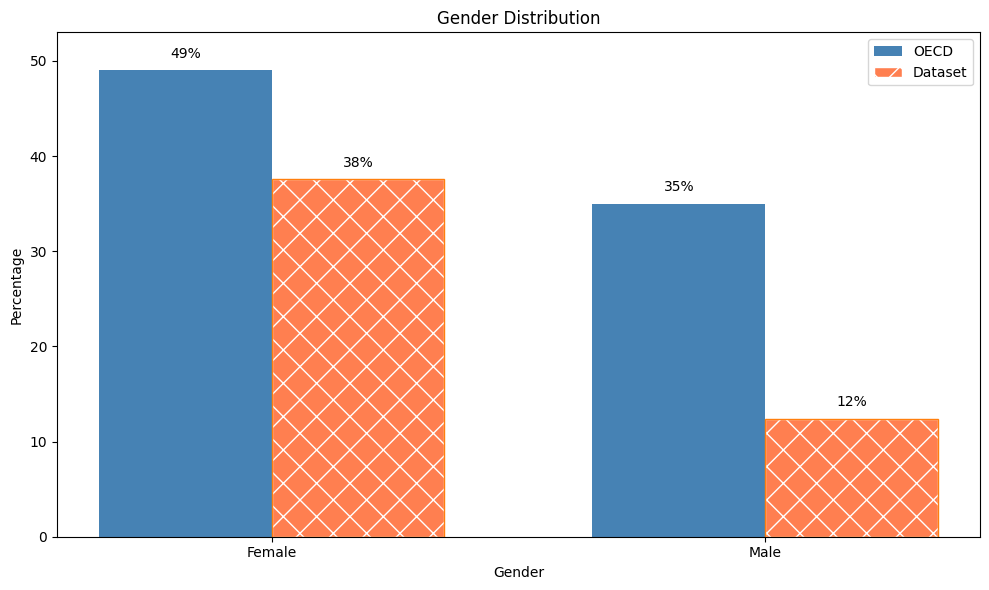

In [9]:
# OECD Data
female_tertiary = 49  # percentage of 25-34 year-old women with tertiary qualification
male_tertiary = 35    # percentage of 25-34 year-old men with tertiary qualification

print(f"OECD Imbalance Ratio is {female_tertiary/male_tertiary:.2f}")

# Data: Calculate percentages
rows_male = len(features[(features.gender == 1) & (labels.graduated == 1)].index)
rows_female = len(features[(features.gender == 0) & (labels.graduated == 1)].index)
total_rows = len(features)

male_percentage = 100 * rows_male / total_rows
female_percentage = 100 * rows_female / total_rows
print(f"Number of rows male graduates: {rows_male}, corresponding to {rows_male/total_rows:.2%} of the data")
print(f"Number of rows female graduates: {rows_female}, corresponding to {rows_female/total_rows:.2%} of the data")
print(f"Dataset Imbalance is {rows_female/rows_male:.2f}\n")

labels_data = ['Male', 'Female']
values_data = [rows_male, rows_female]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(2)

# Bar plot for female tertiary qualification rates
ax.bar(index[0] - bar_width/2, female_tertiary, bar_width, color='steelblue',  label='OECD')
ax.bar(index[0] + bar_width/2, female_percentage, bar_width, color='coral',hatch='X', edgecolor='white',zorder=0, label='Dataset')
ax.bar(index[0] + bar_width/2, female_percentage, bar_width, color='none', edgecolor='tab:orange')

ax.bar(index[1] - bar_width/2, male_tertiary, bar_width, color='steelblue')
ax.bar(index[1] + bar_width/2, male_percentage, bar_width, color='coral',hatch='X', edgecolor='white',zorder=0)
ax.bar(index[1] + bar_width/2, male_percentage, bar_width, color='none', edgecolor='tab:orange')

ax.set_xlabel('Gender')
ax.set_ylabel('Percentage')
ax.set_title('Gender Distribution')
ax.set_xticks(index)
ax.set_xticklabels(['Female', 'Male'])
ax.legend()

# Add text annotations
ax.text(index[0] - bar_width/2, female_tertiary + 1, f'{female_tertiary}%', ha='center', va='bottom')
ax.text(index[1] - bar_width/2, male_tertiary + 1, f'{male_tertiary}%', ha='center', va='bottom')
ax.text(index[0] + bar_width/2, female_percentage + 1, f'{female_percentage:.0f}%', ha='center', va='bottom')
ax.text(index[1] + bar_width/2, male_percentage + 1, f'{male_percentage:.0f}%', ha='center', va='bottom')

plt.ylim(0,53)
plt.tight_layout()


plt.savefig('img/gender_disb_oecd.png', transparent=True)
plt.show()

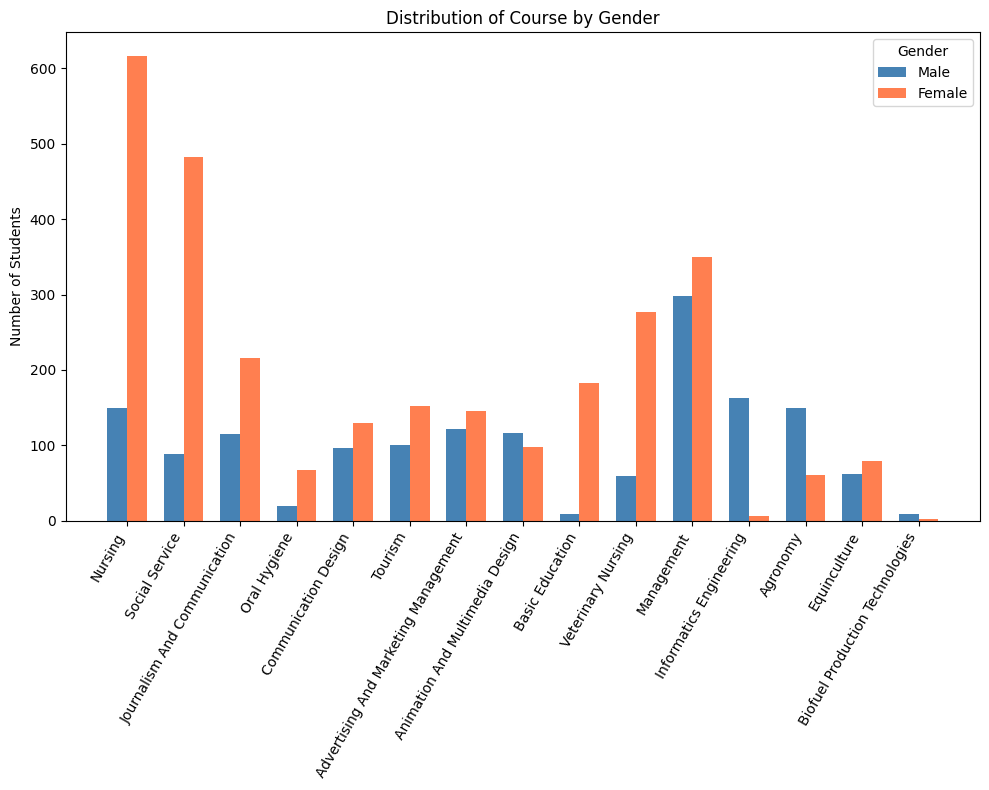

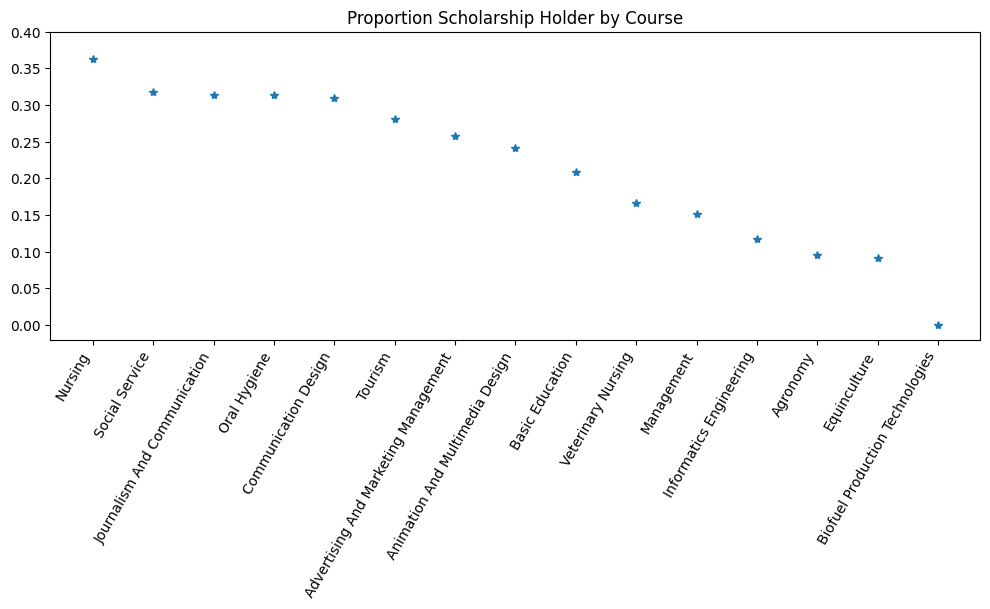

In [10]:
# we had noticed a connection between courses/scholarship holders/gender:

# This sorts features into order from highest scholarship % to lowest
a = features_full[["course", "scholarship_holder"]].groupby('course').mean().reset_index().sort_values(by='scholarship_holder', ascending=False)

c_order = list(a.course)

plot_feature(feature_name='course', 
             features_full=features_full, 
             column_feature='gender',
             order=c_order,
             colors=['coral', 'steelblue'], 
             labels=['Female', 'Male'], 
             show_ratio=False, figsize=(10,8),
             save=True, file_name='course_disp_gender')

_, ax = plt.subplots(1, 1, figsize=(12,4))

ax.plot(a.course, a.scholarship_holder, marker='*', ls='')
ax.set_xticklabels([x.replace('_', ' ').title() for x in a.course], rotation=60, ha='right')
ax.set_ylim(-0.02,0.4)
ax.set_title('Proportion Scholarship Holder by Course');
#We can see that 2 courses with a high proportion of scholarships also have a high proportion of female applicants

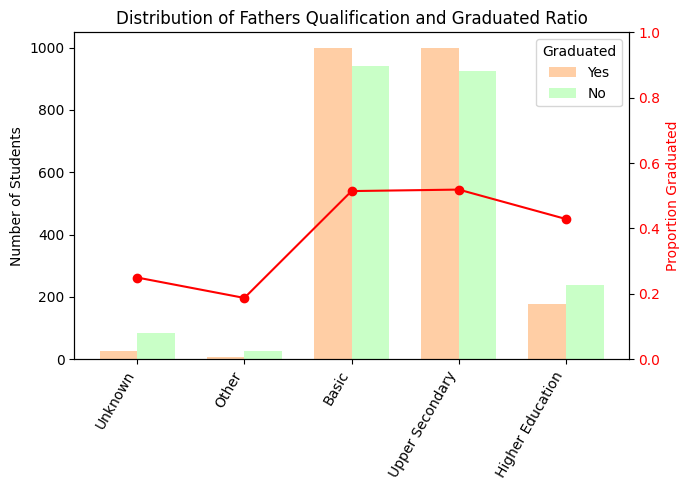

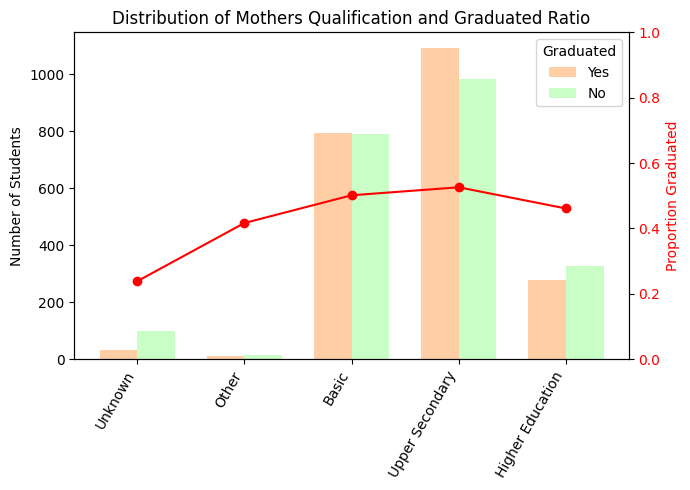

In [11]:
q_order = ['unknown','other','basic','upper_secondary','higher_education',]
plot_feature(feature_name = "fathers_qualification", 
             features_full=features_full, order=q_order,
             save=True, file_name='father_qual_grad')

plot_feature(feature_name = "mothers_qualification", 
             features_full=features_full, order=q_order,
             save=True, file_name='mother_qual_grad')

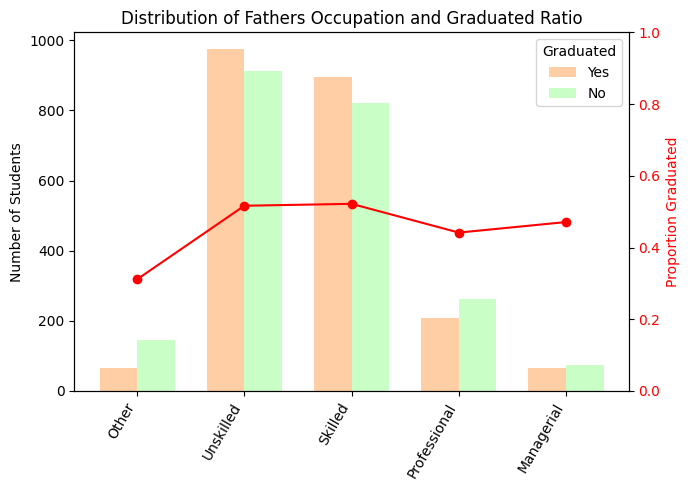

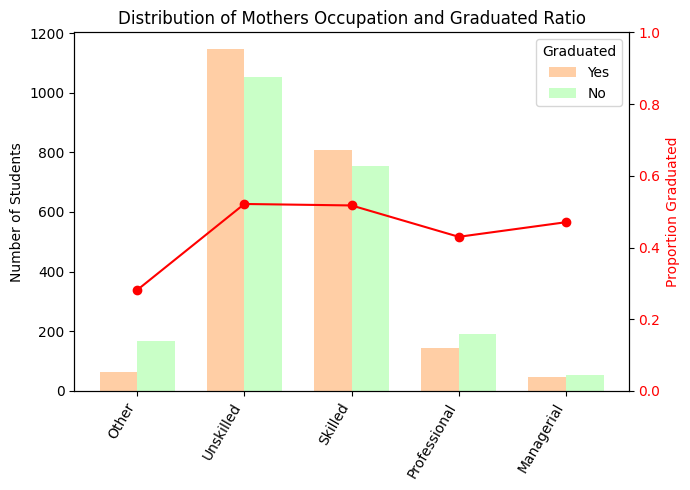

In [12]:
o_order = ['other','unskilled','skilled', 'professional', 'managerial']
plot_feature(feature_name = "fathers_occupation", 
             features_full=features_full, order=o_order,
             save=True, file_name='father_occu_grad')

plot_feature(feature_name = "mothers_occupation", 
             features_full=features_full, order=o_order,
             save=True, file_name='mother_occu_grad')

In [13]:
## order dataset for correllation plotting

df = features.join(labels)

cir = [ 'curricular_units_1st_sem_credited',
 'curricular_units_1st_sem_enrolled',
 'curricular_units_1st_sem_evaluations',
 'curricular_units_1st_sem_approved',
 'curricular_units_1st_sem_grade',
 'curricular_units_1st_sem_without_evaluations',

 'curricular_units_2nd_sem_credited',
 'curricular_units_2nd_sem_enrolled',
 'curricular_units_2nd_sem_evaluations',
 'curricular_units_2nd_sem_approved',
 'curricular_units_2nd_sem_grade',
 'curricular_units_2nd_sem_without_evaluations',]

main_feats = [
 'application_mode_1st_phase_special_contingent_azores_island',
 'application_mode_1st_phase_special_contingent_madeira_island',
 'application_mode_2nd_phase_general_contingent',
 'application_mode_3rd_phase_general_contingent',
 'application_mode_change_of_course',
 'application_mode_change_of_institution_course',
 'application_mode_change_of_institution_course_international',
 'application_mode_holders_of_other_higher_courses',
 'application_mode_international_student_bachelor',
 'application_mode_ordinance_no_533A_99_item_b2_different_plan',
 'application_mode_ordinance_no_533A_99_item_b3_other_institution',
 'application_mode_ordinance_no_612_93',
 'application_mode_ordinance_no_854B_99',
 'application_mode_over_23_years_old',
 'application_mode_short_cycle_diploma_holders',
 'application_mode_technological_specialization_diploma_holders',
 'application_mode_transfer',
 'application_order',
 'course_advertising_and_marketing_management',
 'course_agronomy',
 'course_animation_and_multimedia_design',
 'course_basic_education',
 'course_biofuel_production_technologies',
 'course_communication_design',
 'course_equinculture',
 'course_informatics_engineering',
 'course_journalism_and_communication',
 'course_management',
 'course_oral_hygiene',
 'course_social_service',
 'course_tourism',
 'course_veterinary_nursing',
 'previous_qualification_basic',
 'previous_qualification_higher_education',
 'previous_qualification_other',
 'daytime/evening_attendance',
 'previous_qualification_grade',
 'admission_grade',
 
 'unemployment_rate',
 'inflation_rate',
 'gdp',

 'mothers_qualification_basic',
 'mothers_qualification_higher_education',
 'mothers_qualification_other',
 'mothers_qualification_unknown',
 'fathers_qualification_basic',
 'fathers_qualification_higher_education',
 'fathers_qualification_other',
 'fathers_qualification_unknown',
 'mothers_occupation_managerial',
 'mothers_occupation_other',
 'mothers_occupation_professional',
 'mothers_occupation_skilled',
 'fathers_occupation_managerial',
 'fathers_occupation_other',
 'fathers_occupation_professional',
 'fathers_occupation_skilled',
 'educational_special_needs',
 'debtor',
 'tuition_fees_up_to_date',
 'scholarship_holder',

 'displaced',
 'marital_status_divorced',
 'marital_status_facto union',
 'marital_status_legally separated',
 'marital_status_married',
 'marital_status_widower',
 'age_at_enrollment',
 'international',
 'gender',
 'graduated']

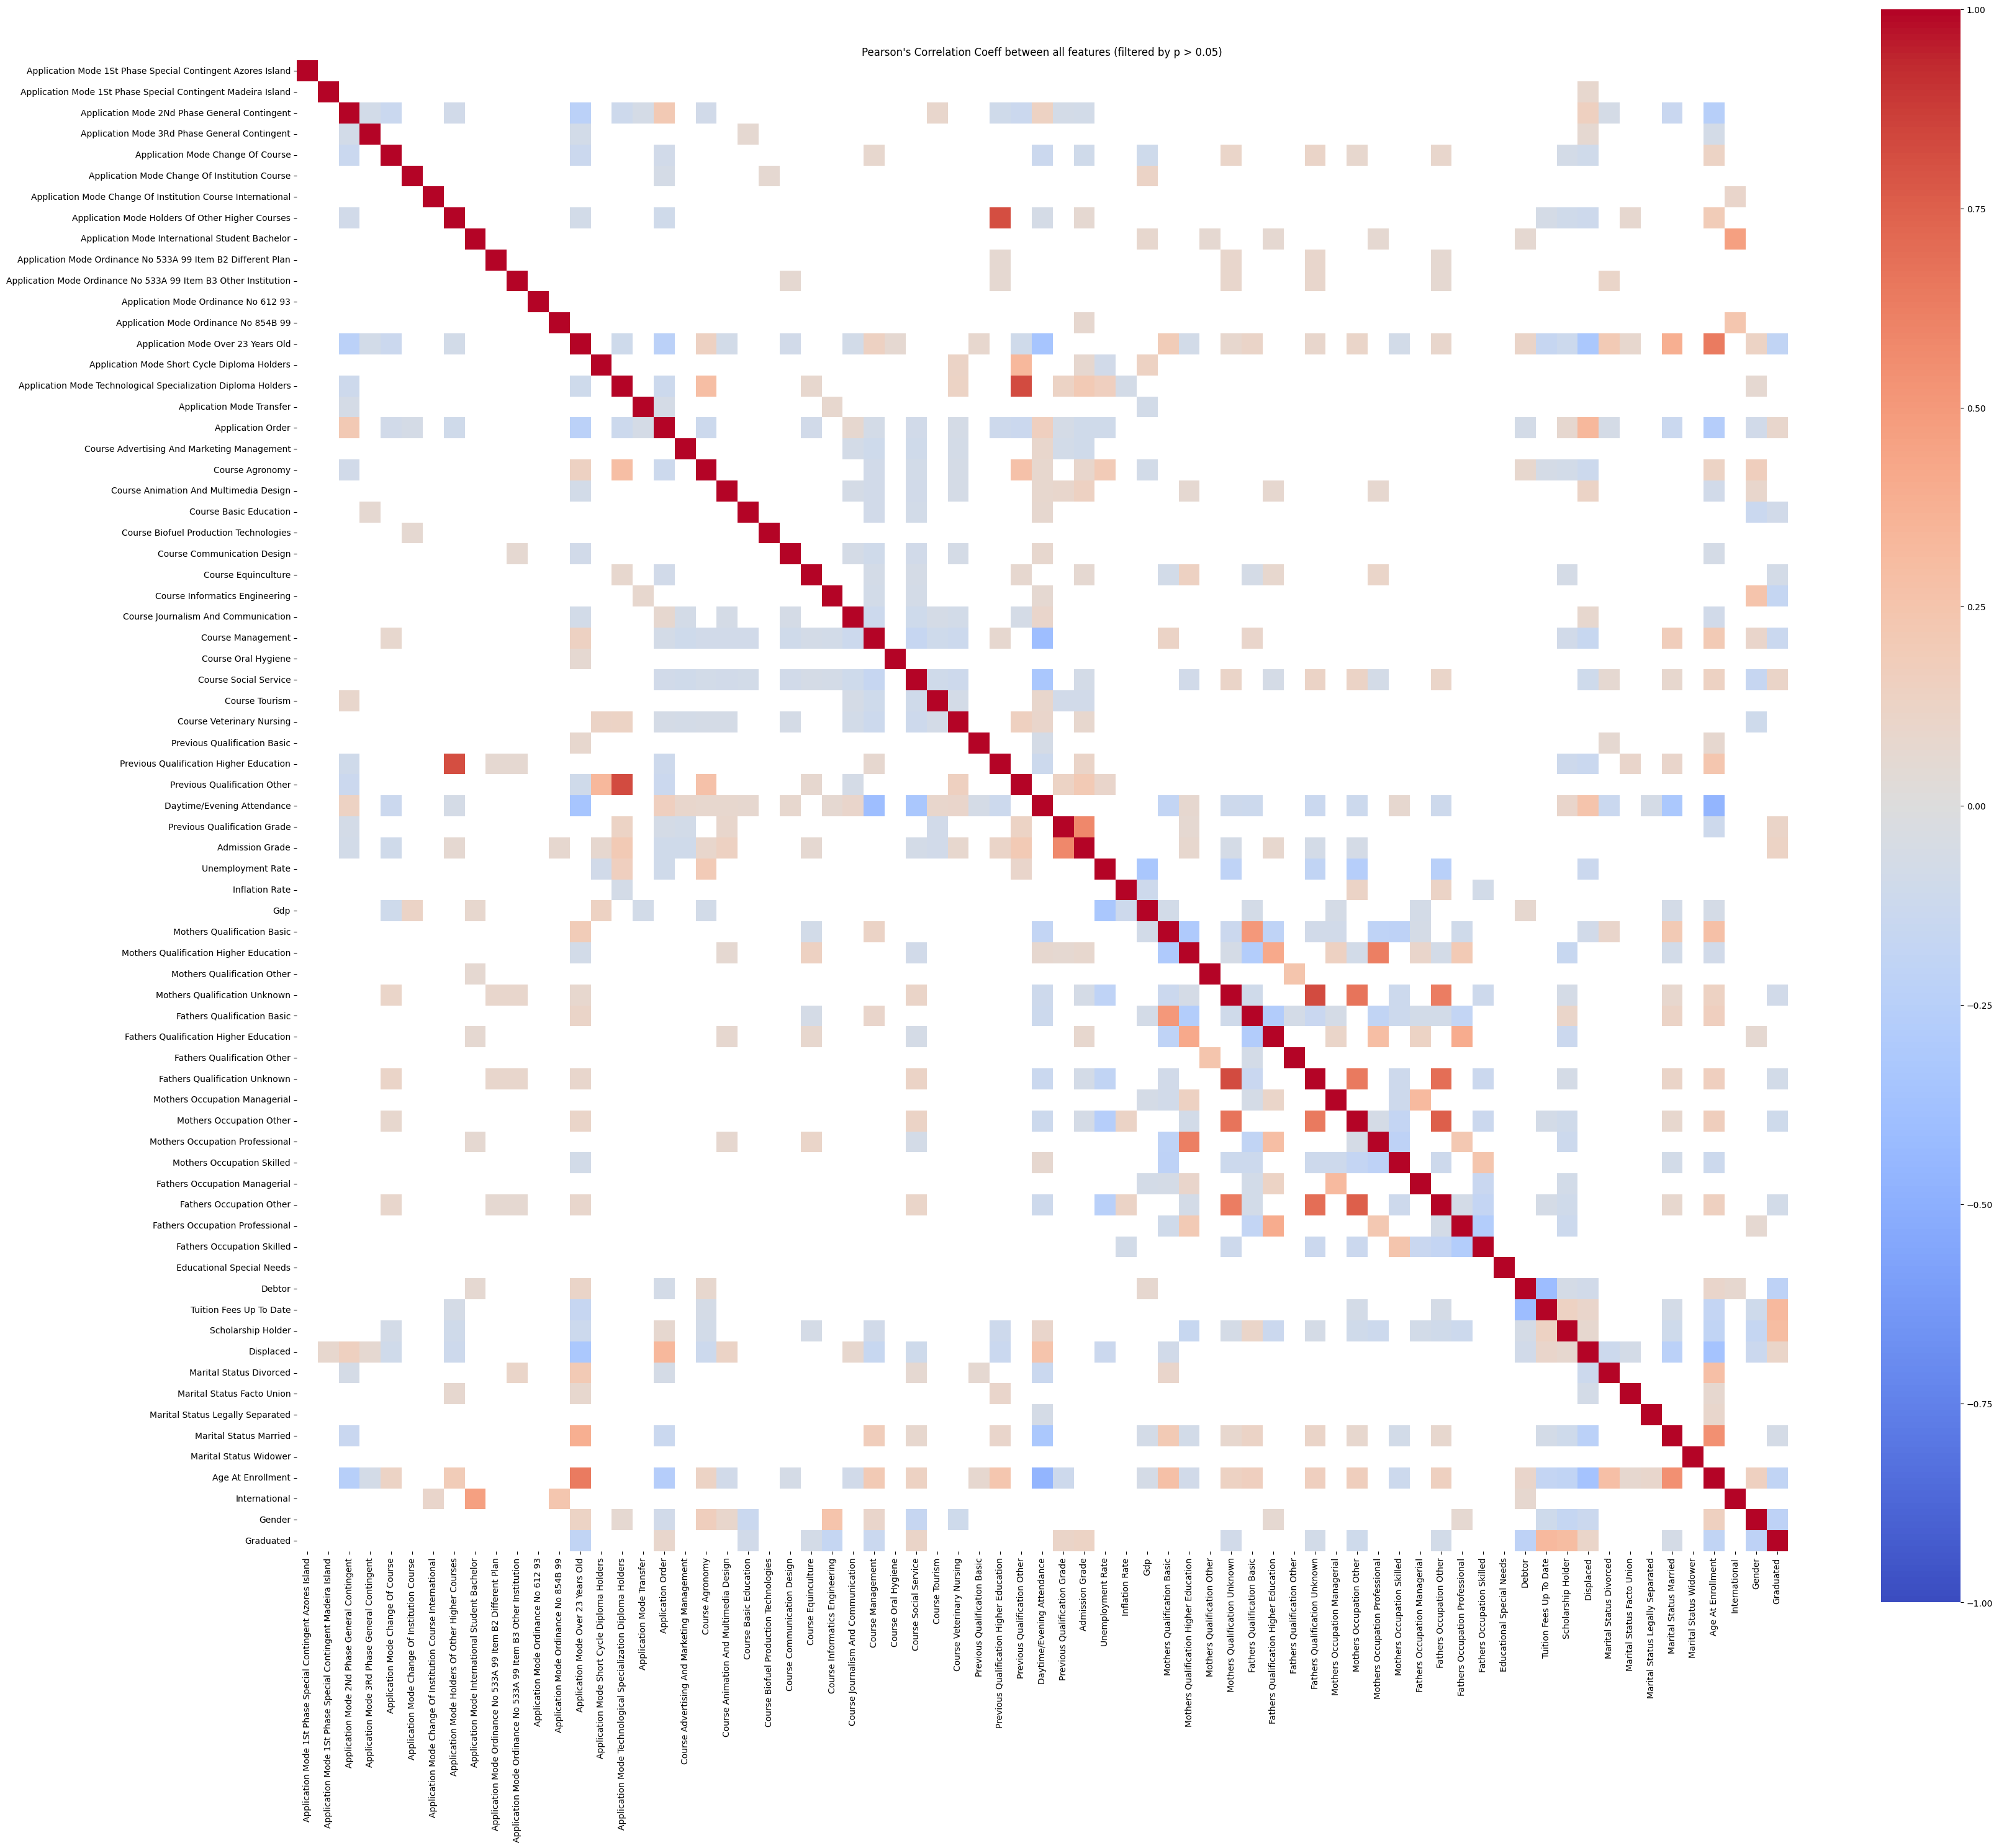

In [14]:
## columns arranged into sections:
# 1st semester info
# 2nd semester info 
# course info
# macro socioeconomic factors
# personal socioeconomic factors
# demographic info
# graduated

if from_begin:
    df = df[main_feats]
else:
    df = df[cir + main_feats]

plot_corr(df=df, figsize=(35,30), show_specific_features=False)

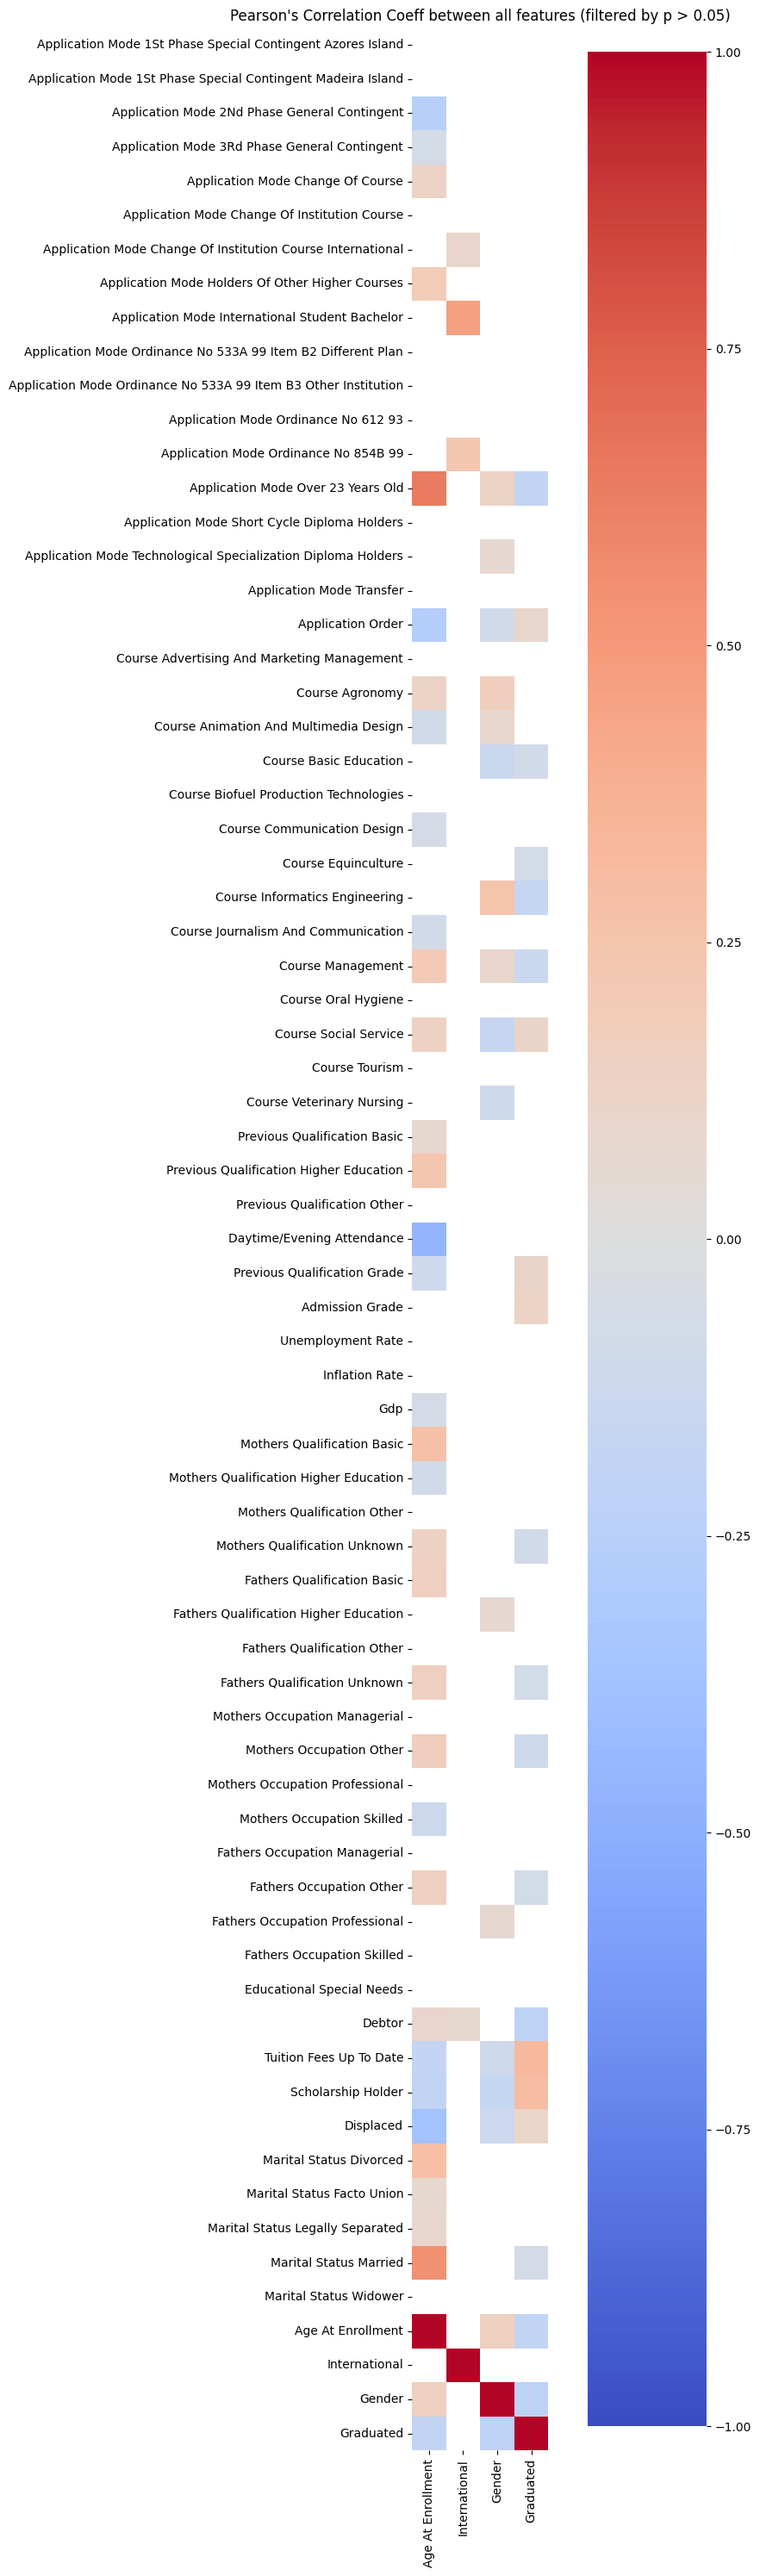

In [15]:
plot_corr(df=df,feature_cols=['age_at_enrollment','international','gender','graduated'], figsize=(10,30), show_specific_features=True)

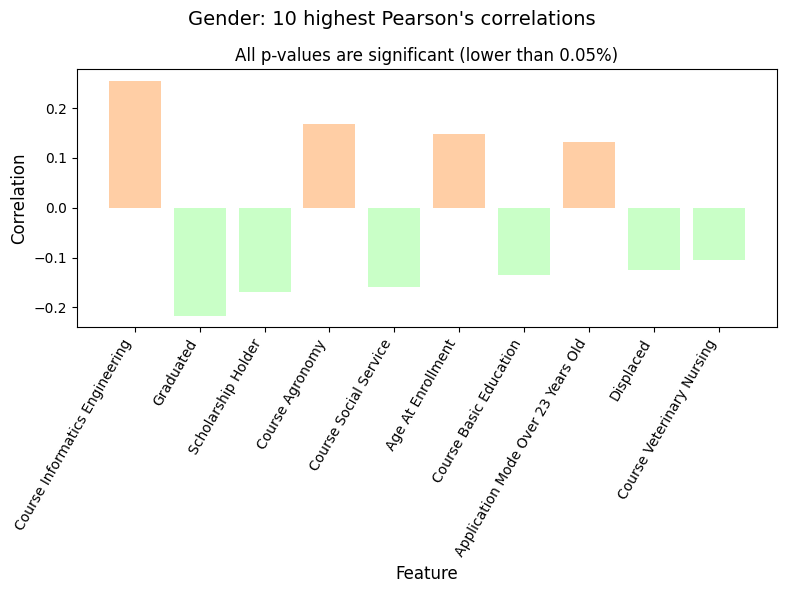

In [16]:
plot_corr(df,feature_cols=['gender'], show_specific_features=True, num_corr=10)

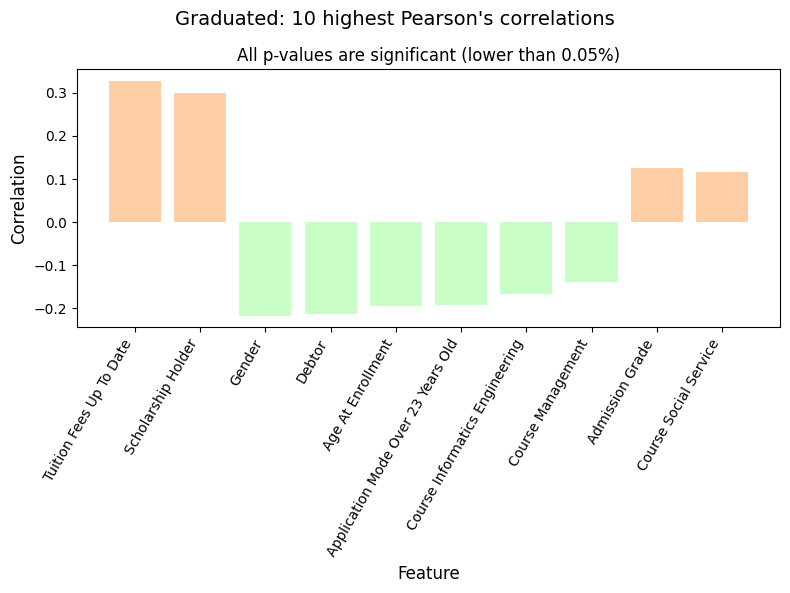

In [17]:
plot_corr(df=df,feature_cols=['graduated'], show_specific_features=True, num_corr=10)

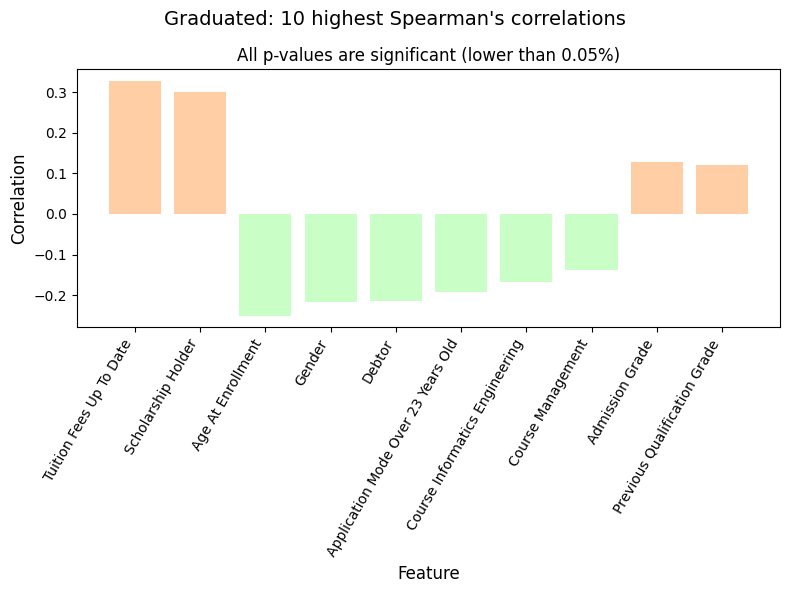

In [18]:
plot_corr(df=df,feature_cols=['graduated'], show_specific_features=True, method="spearman", num_corr=10)

# Baseline Model

In [19]:
logreg = LogisticRegression(max_iter=1000, random_state=seed)

## Base model: 
Logistic regression, logististic regression with fair pca (lambda=0)

In [20]:
logreg_preds = cross_validator(logreg, features, labels)

print("Base model\nclassification report:\n",classification_report(labels, logreg_preds))

print('*'*50)

logreg_preds_db = cross_validator(model=logreg, X=features, y=labels, protected_cols=protected_cols, debias='geometric')

print("Geometric Debias\nclassification report:\n",classification_report(labels, logreg_preds_db))

print('*'*50)

logreg_preds_pca = cross_validator(model=logreg, X=features, y=labels, protected_cols=protected_cols, debias='fairPCA')

print("FairPCA debias\nclassification report:\n",classification_report(labels, logreg_preds_pca))

Base model
classification report:
               precision    recall  f1-score   support

           0       0.75      0.70      0.72      2215
           1       0.71      0.76      0.74      2209

    accuracy                           0.73      4424
   macro avg       0.73      0.73      0.73      4424
weighted avg       0.73      0.73      0.73      4424

**************************************************
Geometric Debias
classification report:
               precision    recall  f1-score   support

           0       0.75      0.68      0.71      2215
           1       0.71      0.77      0.74      2209

    accuracy                           0.73      4424
   macro avg       0.73      0.73      0.72      4424
weighted avg       0.73      0.73      0.72      4424

**************************************************
FairPCA debias
classification report:
               precision    recall  f1-score   support

           0       0.72      0.65      0.68      2215
           1       0

### Remove protected features entirely

1. Focussed:
+ remove gender
+ remove parental features

2. Strict:
+ remove age
+ international
+ special educational needs
+ other fields containing financial information
+ marital status

In [21]:
# filter columns containing protected features
unrestricted = [x for x in features.columns if ('mother' not in x)  and ('father' not in  x) \
                                                                    and (x!='gender')]

unrestricted_2 = [x for x in unrestricted if (x not in ['displaced',
                                                       'educational_special_needs',
                                                       'debtor',
                                                       'tuition_fees_up_to_date',
                                                       'scholarship_holder',
                                                       'age_at_enrollment',
                                                       'international',]) and ('marital_status' not in x)]


In [22]:
features_unres = features[unrestricted].copy()
features_unres_2 = features[unrestricted_2].copy()

logreg_preds_unres = cross_validator(logreg, features_unres, labels)
logreg_preds_unres_2 = cross_validator(logreg, features_unres_2, labels)

print("Unrestricted model\nclassification report:\n",classification_report(labels, logreg_preds_unres))

print('*'*50)

print("Unrestricted (strict) model\nclassification report:\n",classification_report(labels, logreg_preds_unres_2))


Unrestricted model
classification report:
               precision    recall  f1-score   support

           0       0.74      0.69      0.72      2215
           1       0.71      0.75      0.73      2209

    accuracy                           0.72      4424
   macro avg       0.72      0.72      0.72      4424
weighted avg       0.72      0.72      0.72      4424

**************************************************
Unrestricted (strict) model
classification report:
               precision    recall  f1-score   support

           0       0.68      0.65      0.66      2215
           1       0.66      0.70      0.68      2209

    accuracy                           0.67      4424
   macro avg       0.67      0.67      0.67      4424
weighted avg       0.67      0.67      0.67      4424



## Fairness comparison

In [23]:
def plot_scores_and_group_compare(dfs=[], titles=None, suptitle='', color_palette=None, bar_width=0.35, figsize=(15, 6)):
    """
    Plot and compare scores by metric and group from two DataFrames.

    Parameters:
        df1 (DataFrame): First input DataFrame containing scores, metrics, and groups. Can be obtained by using metric_scores() and metric_df()
        df2 (DataFrame): Second input DataFrame containing scores, metrics, and groups. Can be obtained by using metric_scores() and metric_df()
        titles (list, optional): Titles for the plots. Defaults to None, setting it to 'Scores by Metric and Group'-
        color_palette (list, optional): Color palette for the plots. Defaults to None, setting it to 'pastel'.
        bar_width (float, optional): Width of the bars in the plot. Defaults to 0.35.

    Example:
        plot_scores_and_group_compare(gender_log_metric_df, gender_RF_metric_df, titles=['Logistic Regression Gender','Random Forest Classification Gender'], color_palette=['pink', 'skyblue'])
    """

    # Plotting
    fig, axes = plt.subplots(1, len(dfs), figsize=figsize, sharey=True)  # Create subplots side by side ####################

    # Iterate over DataFrames
    for i, (ax, df) in enumerate(zip(axes, dfs)):
        metrics = df['metric'].unique()
        index = range(len(metrics))

        if not color_palette:
          color_palette = sns.color_palette("pastel", n_colors=len(df['group'].unique()))


        for j, group in enumerate(df['group'].unique()):
            values = df[df['group'] == group]['score']
            ax.bar([x + j * bar_width for x in index], values, bar_width, label=group, color=color_palette[j])

        ax.set_xlabel('Metric')
        if titles:
            ax.set_title(titles[i])
        else:
            ax.set_title('Scores by Metric and Group')

        ax.set_xticks([x + bar_width for x in index])
        ax.set_xticklabels(metrics)

    # Set common y-label and legend
    axes[0].set_ylabel('Score')
    axes[-1].legend(title='Group', loc='upper right', bbox_to_anchor=(1.47,1))
    plt.suptitle(suptitle)
    plt.tight_layout()
    plt.show()

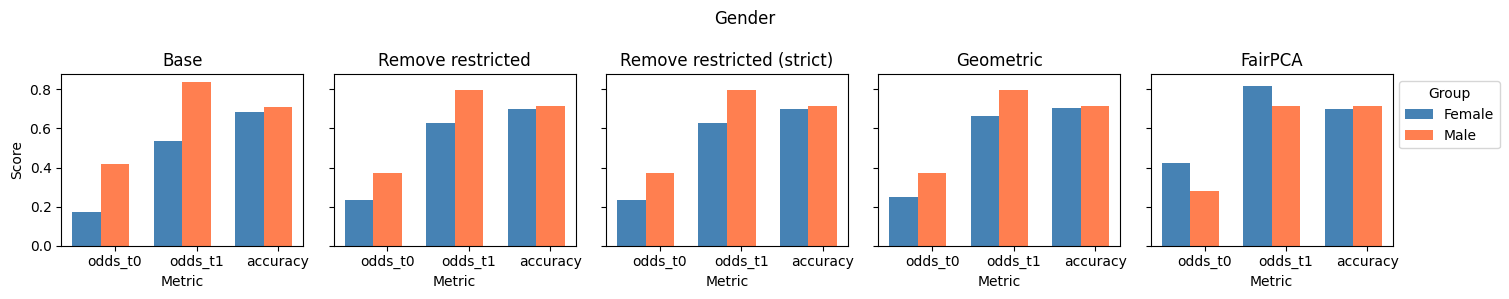

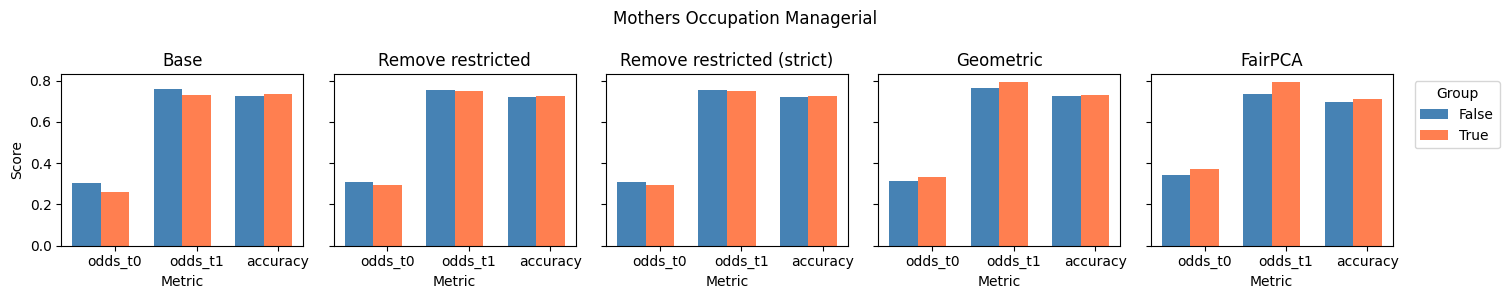

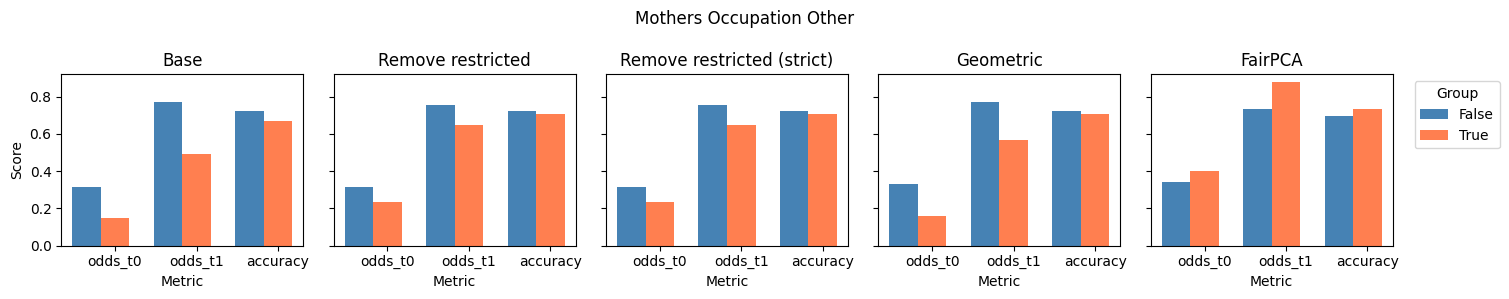

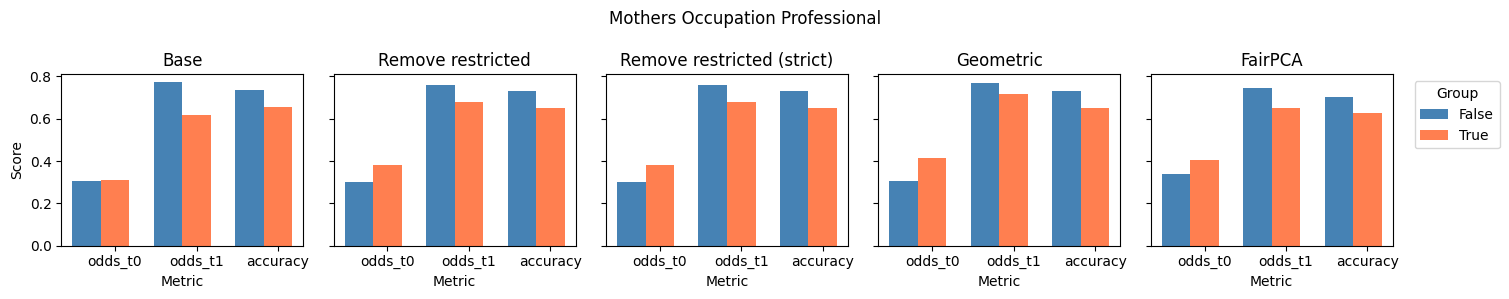

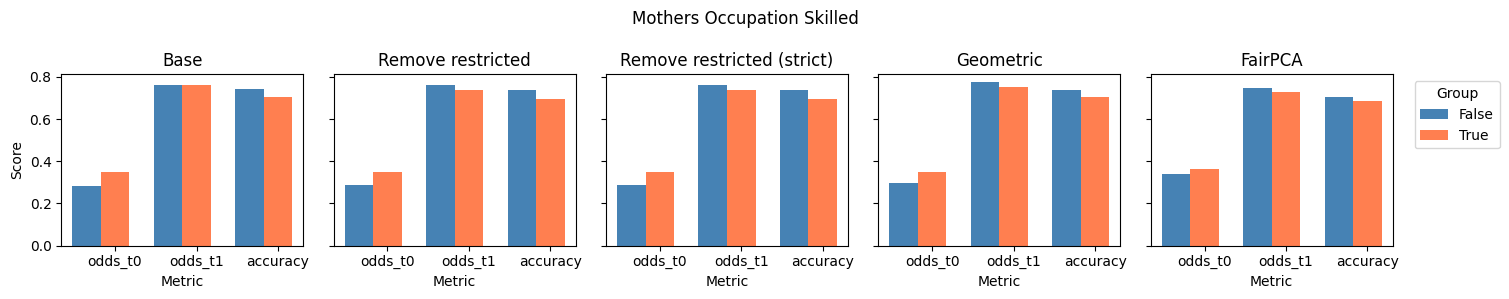

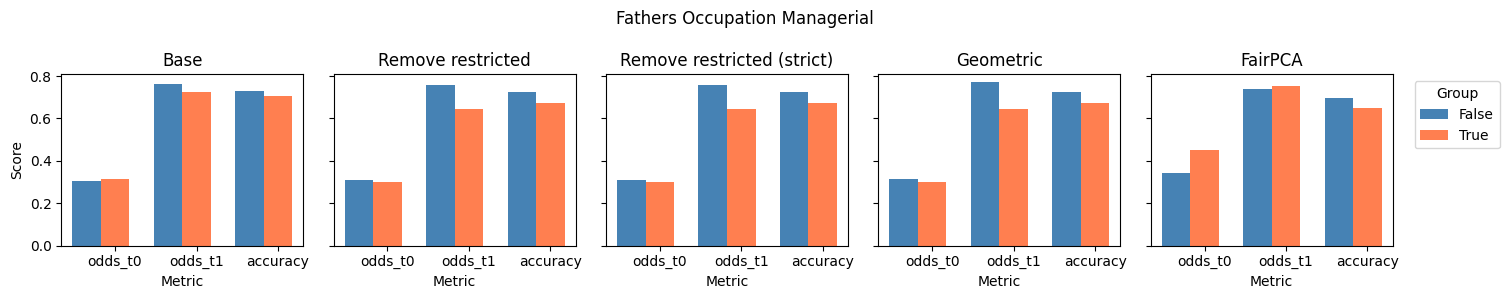

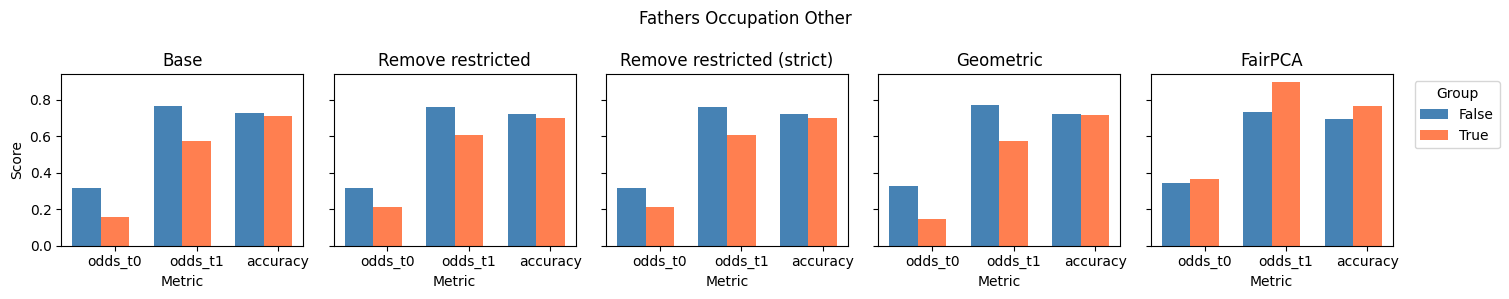

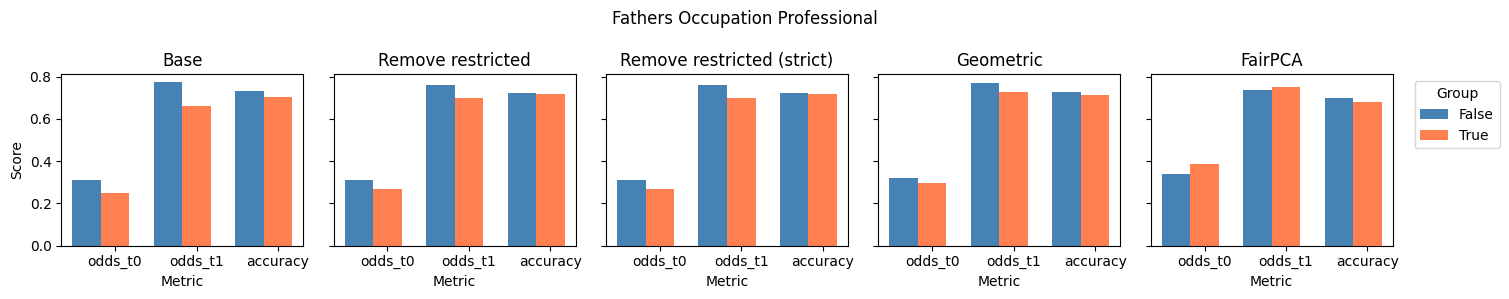

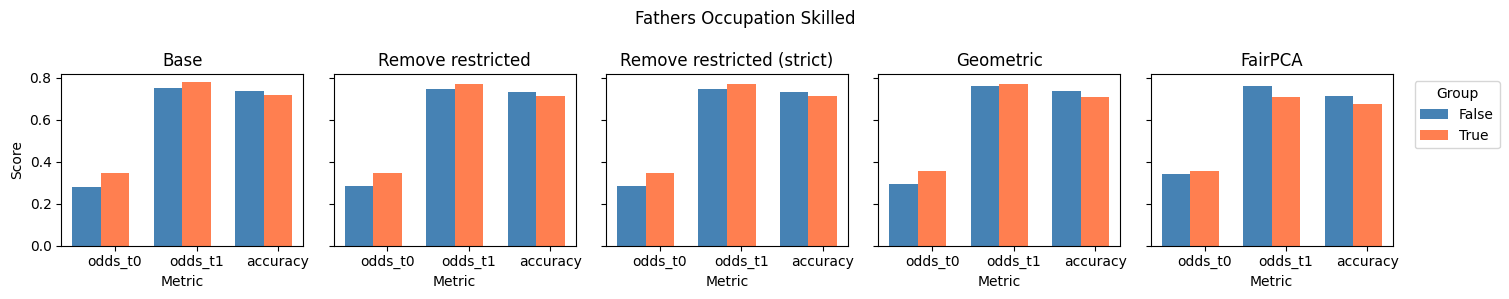

In [24]:
for g in groups:
    if g=='gender':
        gn = ['Female', 'Male']
    else:
        gn = ['False', 'True']

    log_metric_score = metric_scores(y_test=labels, y_pred = logreg_preds, group_test=groups[g])
    log_metric_df = metric_df(log_metric_score, group_names=gn, names=metric_names)

    log_metric_score_geom = metric_scores(y_test=labels, y_pred = logreg_preds_db, group_test=groups[g])
    log_metric_df_geom = metric_df(log_metric_score_geom, group_names=gn, names=metric_names)

    log_metric_score_pca = metric_scores(y_test=labels, y_pred = logreg_preds_pca, group_test=groups[g])
    log_metric_df_pca = metric_df(log_metric_score_pca, group_names=gn, names=metric_names)
        
    log_metric_score_1 = metric_scores(y_test=labels, y_pred = logreg_preds_unres, group_test=groups[g])
    log_metric_df_1 = metric_df(log_metric_score_1, group_names=gn, names=metric_names)

    log_metric_score_2 = metric_scores(y_test=labels, y_pred = logreg_preds_unres, group_test=groups[g])
    log_metric_df_2 = metric_df(log_metric_score_2, group_names=gn, names=metric_names)


    plot_scores_and_group_compare([log_metric_df,log_metric_df_1, log_metric_df_2,log_metric_df_geom, log_metric_df_pca], 
                                  titles=['Base', 'Remove restricted', 'Remove restricted (strict)','Geometric', 'FairPCA'],
                                  suptitle=f'{g.replace("_", " ").title()}', 
                                  color_palette=['steelblue', 'coral'], 
                                  figsize=(15,3))
    

## Look at first principle component

In [25]:
[weights_origin_data, weights_np, _], pca = feature_weights(features=features, protected_cols=protected_cols, labels=labels,
                                                         model=LogisticRegression(max_iter=1000,  random_state=seed), top_n=10)          

In [26]:
# Base model coefs:
weights_origin_data

,coef,odds
tuition_fees_up_to_date,2.492,12.085
scholarship_holder,1.119,3.062
marital_status_facto union,0.900,2.459
application_mode_international_student_bachelor,0.702,2.018
previous_qualification_basic,0.646,1.908
marital_status_married,0.449,1.567
mothers_qualification_other,0.418,1.520
previous_qualification_higher_education,0.357,1.429
fathers_occupation_other,0.269,1.308
application_mode_ordinance_no_854B_99,0.265,1.303


In [27]:
# principle component coefs:
weights_np

,coef,odds
9,1.881,6.560
11,1.473,4.364
52,1.224,3.400
45,1.028,2.795
8,0.873,2.393
12,0.739,2.094
48,0.684,1.983
55,0.577,1.780
20,0.563,1.756
50,0.561,1.753


In [28]:
# look at PCA component that has the highest coefficient in the model
# so we can look into its make up:
pca_comp = weights_np.index[0]

comp = list(pca.U[pca_comp])

cols = [x for x in features.columns if x not in protected_cols]

pca_1 = [x for x in zip(comp, cols)]

pca_1.sort(reverse=True, key=lambda x: abs(x[0]))

# just the 10 largest contributors, because there are many features!
pca_1[:10]

[(0.6619389625411676, 'scholarship_holder'),
 (-0.4371381464093854, 'inflation_rate'),
 (0.3815059474958344, 'age_at_enrollment'),
 (0.32744801335488666, 'international'),
 (-0.15548572245034203, 'application_order'),
 (0.12030349705908805,
  'application_mode_1st_phase_special_contingent_madeira_island'),
 (0.10882321092630137, 'application_mode_2nd_phase_general_contingent'),
 (0.08530800520290685, 'tuition_fees_up_to_date'),
 (-0.0785189736720043, 'educational_special_needs'),
 (0.06012639950776844, 'unemployment_rate')]

Lambda 0.0 completed
Lambda 0.1 completed
Lambda 0.2 completed
Lambda 0.3 completed
Lambda 0.4 completed
Lambda 0.5 completed
Lambda 0.6 completed
Lambda 0.7 completed
Lambda 0.8 completed
Lambda 0.9 completed
Lambda 1.0 completed


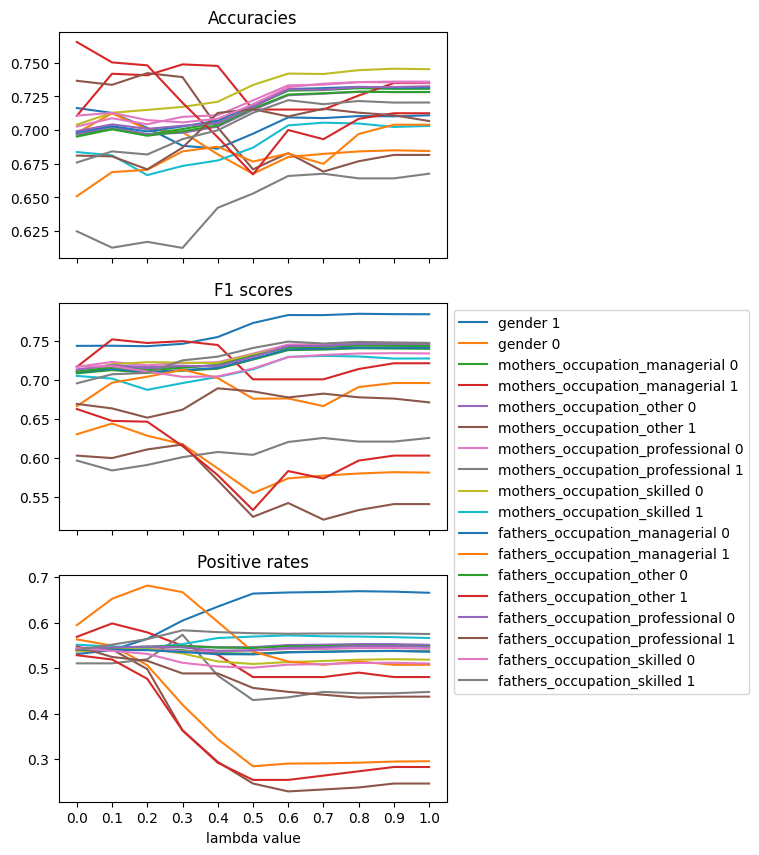

In [29]:
lambda_values, accuracies, f1_scores, positive_rates = tune_lambda(model=LogisticRegression(max_iter=1000, random_state=seed), X=features, y=labels, protected_cols=protected_cols, groups=groups)

plot_tune_lambda(lambda_values, accuracies, f1_scores, positive_rates)

## Look into shap explainers

In [30]:
# Looking at a basic logreg model, no debiasing/pca etc.
logreg = LogisticRegression(max_iter=1000, random_state=seed)

logreg.fit(features, labels)

feats = list(logreg.feature_names_in_)

In [31]:
explainer_LR = shap.Explainer(logreg, features, feature_names=np.array(feats))

shap_values_LR = explainer_LR(features)

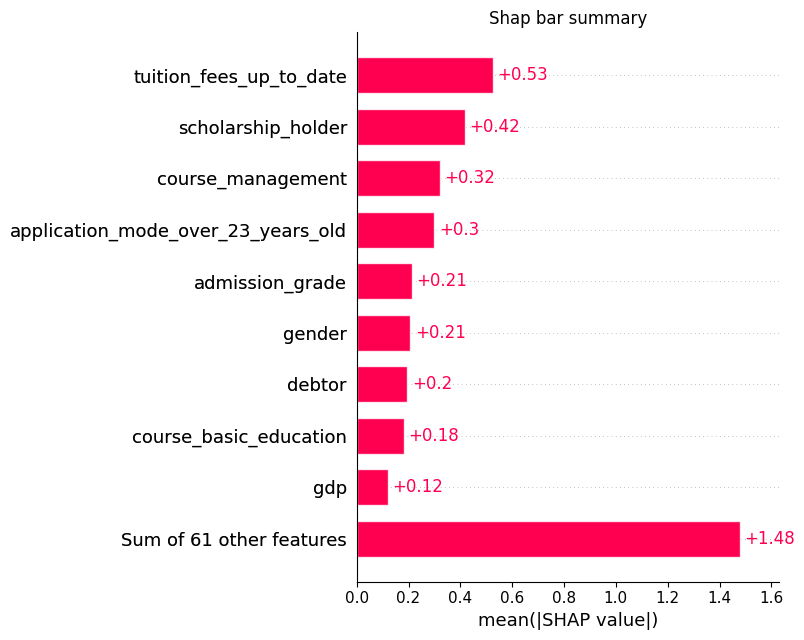

In [32]:
shap.plots.bar(shap_values_LR, max_display=10,show=False)
plt.title(f'Shap bar summary')
plt.tight_layout()

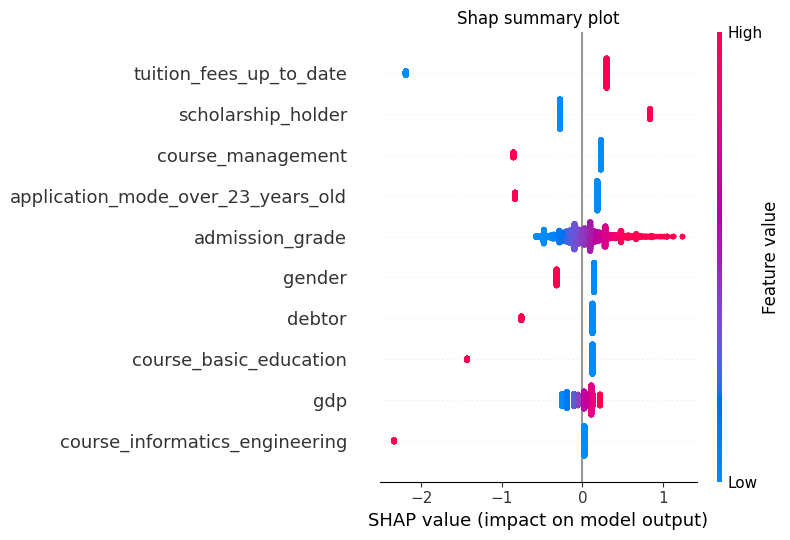

In [33]:
shap.summary_plot(shap_values_LR.values.astype('float64'), 
                  features.astype('float64'), 
                  feature_names=feats, 
                  max_display=10, 
                  show=False)
plt.title(f'Shap summary plot')
plt.tight_layout()

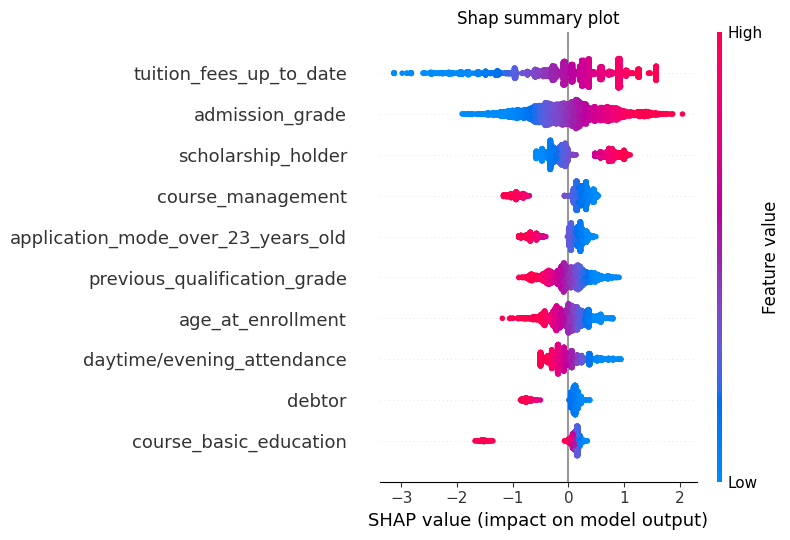

In [34]:
res = [x for x in features.columns if x not in unrestricted]

debiased = debias_features(features, res)

logreg = LogisticRegression(max_iter=1000, random_state=seed)

logreg.fit(debiased, labels)

feats = list(logreg.feature_names_in_)

explainer_LR = shap.Explainer(logreg, debiased, feature_names=np.array(feats))

shap_values_LR = explainer_LR(debiased)

shap.summary_plot(shap_values_LR.values.astype('float64'), 
                  debiased.astype('float64'), 
                  feature_names=feats, 
                  max_display=10, 
                  show=False)
plt.title(f'Shap summary plot')
plt.tight_layout()

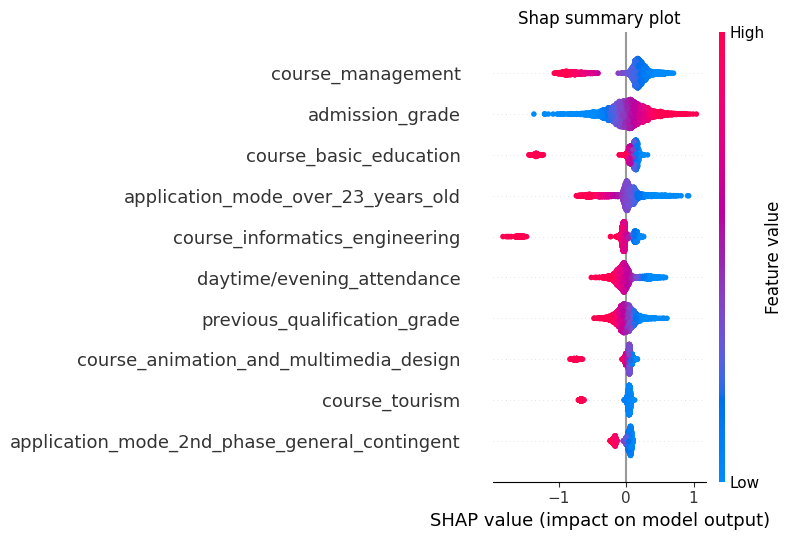

In [35]:
res = [x for x in features.columns if x not in unrestricted_2]

debiased = debias_features(features, res)

logreg = LogisticRegression(max_iter=1000, random_state=seed)

logreg.fit(debiased, labels)

feats = list(logreg.feature_names_in_)

explainer_LR = shap.Explainer(logreg, debiased, feature_names=np.array(feats))

shap_values_LR = explainer_LR(debiased)

shap.summary_plot(shap_values_LR.values.astype('float64'), 
                  debiased.astype('float64'), 
                  feature_names=feats, 
                  max_display=10, 
                  show=False)
plt.title(f'Shap summary plot')
plt.tight_layout()